In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd


bins = 32
with open ('calibration.npy', 'rb') as f:
    hmatrix = np.load(f)
    left_g_int = np.load(f)
    left_r_int = np.load(f)
    right_g_int = np.load(f)
    right_r_int =np.load(f)

with open('frame.npy', 'rb') as f:
    test_frame = np.load(f)

with open('segmented.npy', 'rb') as f:
    segmented = np.load(f)

print(hmatrix.shape,left_g_int.shape,left_r_int.shape,right_g_int.shape,right_r_int.shape,test_frame.shape, segmented.shape)
hmatrix1d = hmatrix.flatten()

(32, 32) (30, 30) (30, 30) (30, 30) (30, 30) (720, 1280, 3) (240, 427)


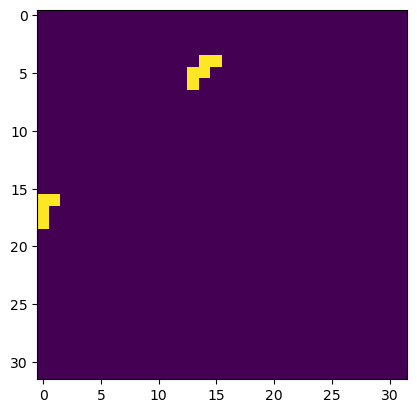

In [12]:
_, hmatrix = cv2.threshold(hmatrix, 30, 255, cv2.THRESH_BINARY)
hmatrix_g = np.tril(hmatrix)
hmatrix_r = np.triu(hmatrix)
hmatrix_g1d = hmatrix_g.flatten()
hmatrix_r1d = hmatrix_r.flatten()
plt.imshow(hmatrix_g)
plt.show()

In [13]:
def image_segmentation(frame):
    # RG chromaticity of frame
    np.seterr(invalid='ignore')
    I = frame.sum(axis=2)
    I[I == 0] = 100000

    frame_r = frame[:,:,2] / I
    frame_g = frame[:,:,1] / I
    
    frame_r_int = (frame_r*(bins-1)).astype(int)
    frame_g_int = (frame_g*(bins-1)).astype(int)

    back_projection_g = hmatrix_g1d[frame_g_int.flatten()*bins + frame_r_int.flatten()].reshape(frame_r.shape)
    back_projection_r = hmatrix_r1d[frame_g_int.flatten()*bins + frame_r_int.flatten()].reshape(frame_r.shape)
    
    #masked = cv2.bitwise_and(frame, frame, mask = back_projection)

    return back_projection_g, back_projection_r

In [22]:
def blob_detection(frame):
    
    center = [0,0]
    #_, thresh = cv2.threshold(frame, 30, 255, cv2.THRESH_BINARY)
    thresh = frame
    indices = np.where(thresh == 255)
    if indices[0].size > 225:
        center[0] = indices[0].mean()
        center[1] = indices[1].mean()

    center = np.array(center, dtype=np.uint16) 

    return center

In [15]:
def blob_detection2(frame):
    #plt.imshow(frame)
    #plt.show()
    _, thresh = cv2.threshold(frame, 30, 255, cv2.THRESH_BINARY)
    M = cv2.moments(thresh)

    # Calculate the centroid coordinates
    centroid_x = int(M["m10"] / M["m00"])
    centroid_y = int(M["m01"] / M["m00"])

    center = [centroid_x, centroid_y]
    
    return thresh, center

In [16]:
def downsample(frame):
        '''
        reduce resolution
        '''
        res = (427, 240)
        return cv2.resize(frame, res, interpolation = cv2.INTER_NEAREST)

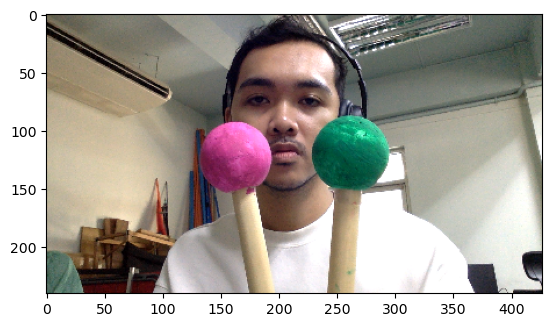

In [17]:
frame_width = 854
frame_height = 480
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)
#create a 5 second delay to allow the camera to warm up
time.sleep(5)
_, test_frame = cam.read()
type(test_frame)
test_frame = cv2.flip(test_frame, 1)
test_frame = downsample(test_frame)
cam.release()
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
plt.show()


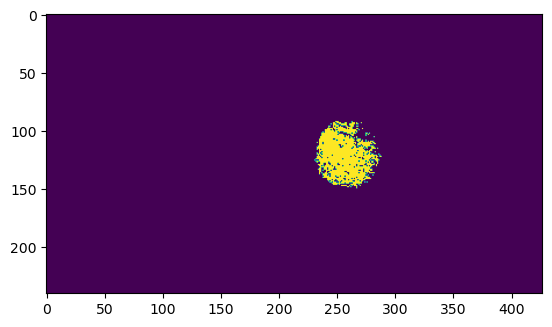

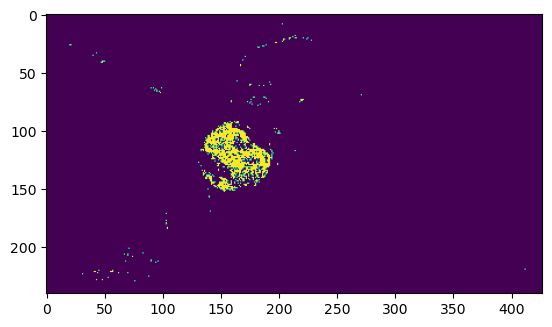

In [18]:
bp_g, bp_r = image_segmentation(test_frame)
plt.imshow(bp_g)
plt.show()
plt.imshow(bp_r)
plt.show()

Average execution time: 40.38 milliseconds
Average frame rate:  24.761810303094705
[119 161]


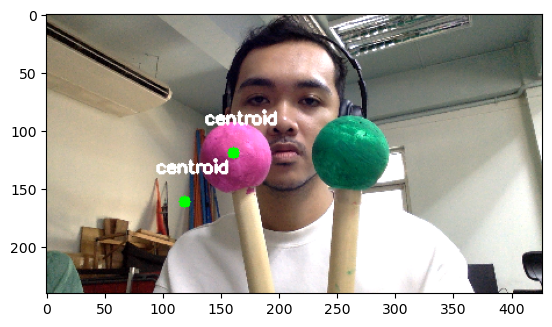

In [27]:
start = time.time()
center = blob_detection(bp_r)
# Draw a circle at the centroid coordinates on the original image
cv2.circle(test_frame, (center[1], center[0]), 5, (0, 255, 0), -1)
cv2.putText(test_frame, "centroid", (center[1] - 25, center[0] - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
end = time.time()
elapsed = end - start
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))
print("Average frame rate: ", 1/elapsed)
print(center)

In [32]:
ind = np.where(np.logical_and(bp_r>0, bp_r<255))
print(ind)

(array([], dtype=int64), array([], dtype=int64))


In [154]:
start = time.time()
a = np.where(thresh == 255)
print(a[0].mean(), a[1].mean())
end = time.time()
elapsed = end - start
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))

127.47119847119848 272.949494949495
Average execution time: 1.41 milliseconds


In [160]:
start = time.time()
M = cv2.moments(thresh)

# Calculate the centroid coordinates
centroid_x = int(M["m10"] / M["m00"])
centroid_y = int(M["m01"] / M["m00"])

center = [centroid_x, centroid_y]
end = time.time()
elapsed = end - start
print(center)
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))

[272, 127]
Average execution time: 9.56 milliseconds


In [189]:
indices = np.where(bp_g == np.amax(bp_g))
print(indices[1].size)
y = indices[0].mean().astype(int)
x = indices[1].mean().astype(int)

956


Average execution time: 200.50 milliseconds
Average frame rate:  4.987430066292101


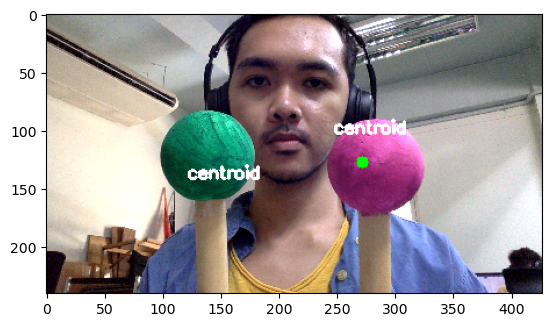

In [190]:
start = time.time()
thresh, center2 = blob_detection2(bp_r)
# Draw a circle at the centroid coordinates on the original image
cv2.circle(test_frame, (y, x), 5, (0, 255, 0), -1)
cv2.putText(test_frame, "centroid", (y, x),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
end = time.time()
elapsed = end - start
print("Average execution time: {0:.2f} milliseconds".format(elapsed*1000))
print("Average frame rate: ", 1/elapsed)

In [ ]:
img = cv2.imread('physics-experiments/opencv-logo-white.jpg', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)


In [ ]:
a = (1,2)
b = np.array((1,2), dtype=np.uint16)
print(b)